#### Import Statements

In [1]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

import openai
import pandas as pd
import numpy as np
import torch
import textstat
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.tokenize import sent_tokenize
from transformers import pipeline, GPT2LMHeadModel, GPT2Tokenizer
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rohan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\rohan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


#### Load Models

In [2]:
semantic_model = SentenceTransformer('all-MiniLM-L6-v2')
gpt2_model = GPT2LMHeadModel.from_pretrained('gpt2')
gpt2_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
gpt2_model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

#### Coherence + Readability score calculation

In [3]:
SIMILARITY_THRESHOLD = 0.6
FACT_MATCH_THRESHOLD = 0.45


def story_coherence_score(text):
    sentences = sent_tokenize(text)
    if len(sentences) < 2:
        coherence_sim = 0.0
    else:
        embeddings = semantic_model.encode(sentences)
        sims = [cosine_similarity(embeddings[i].reshape(1, -1), embeddings[i+1].reshape(1, -1))[0][0] for i in range(len(embeddings)-1)]
        coherence_sim = np.mean(sims)

    try:
        readability_score = textstat.flesch_reading_ease(text)
        readability_scaled = min(readability_score / 100.0, 1.0)
    except:
        readability_score = 0.0
        readability_scaled = 0.0

    combined_score = round((0.7 * coherence_sim + 0.3 * readability_scaled), 3)
    return coherence_sim, readability_score, combined_score

#### Perplexity Calculation

In [4]:
def calculate_perplexity(text):
    encodings = gpt2_tokenizer(text, return_tensors="pt", truncation=True, max_length=1024)
    with torch.no_grad():
        outputs = gpt2_model(**encodings, labels=encodings["input_ids"])
        loss = outputs.loss
        perplexity = torch.exp(loss)
    return round(perplexity.item(), 3)

#### Similarity Calculation

In [5]:
def evaluate_story(caption, facts_text, story_text):
    story_vec = semantic_model.encode([story_text])[0].reshape(1, -1)
    caption_vec = semantic_model.encode([caption])[0].reshape(1, -1)
    summary_vec = semantic_model.encode([facts_text])[0].reshape(1, -1)
    return cosine_similarity(caption_vec, story_vec)[0][0], cosine_similarity(summary_vec, story_vec)[0][0]

#### Hallucination Rate Calculation

In [6]:
def hallucination_rate(summary_sents, story_sents):
    fact_vecs = semantic_model.encode(summary_sents)
    story_vecs = semantic_model.encode(story_sents)
    hallucinated = sum(1 for sv in story_vecs if max(cosine_similarity(sv.reshape(1, -1), fv.reshape(1, -1))[0][0] for fv in fact_vecs) < 0.4)
    return round(hallucinated / len(story_sents), 3)

#### Fact-Check Accuracy

In [7]:
def fact_check_accuracy(summary_facts, story_sents, threshold=FACT_MATCH_THRESHOLD):
    summary_vecs = semantic_model.encode(summary_facts)
    story_vecs = semantic_model.encode(story_sents)
    scores = [max(cosine_similarity(sf.reshape(1, -1), sv.reshape(1, -1))[0][0] for sv in story_vecs) for sf in summary_vecs]
    supported = [(summary_facts[i], round(score, 3)) for i, score in enumerate(scores) if score >= threshold]
    unsupported = [(summary_facts[i], round(score, 3)) for i, score in enumerate(scores) if score < threshold]
    return round(len(supported) / len(summary_facts), 3), supported, unsupported

#### Sample Test

In [8]:
caption = "a man in a red jacket riding a small horse"

summary = "the mid-20th century, Australian horseman and writer Ern Pedler embarked on a remarkable solo journey across the vast and arid landscapes of the Australian Outback. Dressed in traditional riding attire, including a wide-brimmed hat and durable riding clothes, Pedler traversed the desolate terrains on horseback, documenting his experiences and the challenges faced in such a remote environment. His journey not only showcased his resilience and horsemanship but also highlighted the profound solitude and beauty of the Australian wilderness. Pedler\'s writings, such as \"The Big Lonely Horse,\" provide a vivid account of his adventures and the deep bond formed with his horse during this expedition."

story_text = """
**Title: "The Big Lonely Horse"**

**Act 1: The Journey Begins**

The sun hung low over the horizon, casting a golden hue across the barren landscape of the Australian Outback. Ern Pedler, a rugged man in his late thirties, stood beside his small horse, a sturdy chestnut mare named Ruby. Dressed in a vibrant red jacket that flapped gently in the warm breeze, he looked every bit the adventurous horseman he aspired to be. The wide-brimmed hat on his head cast a shadow over his deeply set eyes, which sparkled with a blend of determination and apprehension.

“Ready, Ruby?” he murmured, reaching out to stroke her mane. The mare whinnied softly, as if in response, and Ern felt a surge of affection. Together, they would traverse the vast stretches of the Outback, a journey that would test both their limits.

As Ern mounted Ruby, he took a moment to absorb the scene around him. The land stretched endlessly, dotted with rugged hills and scattered shrubs, the silence only broken by the distant call of a kookaburra. With a last glance at the small town he was leaving behind, he nudged Ruby forward, the journey of a lifetime beginning with a soft thud of hooves against the parched earth.

Weeks slipped by, and Ern documented every moment in his leather-bound journal. He wrote about the biting heat of noon, the chill of night, and the ever-present companionship of Ruby. Each day brought new challenges; from navigating the arid terrain to foraging for water, Ern learned to read the land like a seasoned tracker. He recalled a particular day when they stumbled upon a small waterhole, its surface glistening like jewels under the midday sun.

“Look at that, girl,” Ern said, dismounting and leading Ruby to the water. “A well-deserved treat!” He watched as she drank eagerly, and he couldn’t help but smile at the bond they were forging, a connection deeper than he had ever known.

But solitude often weighed heavily on his heart. The vastness of the Outback, while breathtaking, also felt suffocating. On one particularly lonely evening, as he settled down by a crackling campfire, Ern opened his journal and began to write.

“The Outback is a paradox,” he penned. “It is both beautiful and cruel. It teaches me resilience, yet reminds me of my isolation. Ruby, my only companion, seems to sense my thoughts. She stands by, patient and loyal, as if she embodies the spirit of this land.”

**Act 2: Trials and Tribulations**

The following weeks brought unforeseen trials. A fierce storm blew through one night, the winds howling like wild beasts and the rain pelting down in sheets. Ern had to tie Ruby securely to a nearby tree to keep her from bolting. As the tempest raged, Ern huddled beneath a rocky outcrop, heart pounding in his chest.

“Stay with me, Ruby,” he called out, his voice almost lost in the roar of the storm. “We’ll make it through this!”

When dawn broke, the world was transformed. The storm had left behind a trail of destruction, and Ern found himself standing in a landscape he barely recognized. Trees were uprooted, and the ground was a muddy mess. It took hours to find Ruby, who was frightened but unharmed, trembling beneath the remnants of a fallen branch.

“Thank goodness you’re okay!” Ern exclaimed, relief washing over him as he embraced her neck. “We’re a pair, aren’t we? We’ll face this together.”

As they pressed on, Ern encountered a group of traveling cattlemen. The men, rough around the edges but warm-hearted, welcomed him with open arms. They shared stories over a campfire and taught him survival skills that would prove invaluable. Ern felt a renewed sense of hope, a reminder that even in the vastness of the Outback, there were bonds to be formed.

One evening, as they sat beneath a canopy of stars, Ern shared his dreams of writing about his journey.

“I want people to feel what I feel out here,” he confessed, his voice soft. “To understand the beauty and the struggle.”

One of the men, a grizzled fellow named Jack, leaned forward. “You’re living a story, Ern. Don’t just write about it—let it flow through you. This land has a way of speaking if you listen close enough.”

Inspired, Ern returned to his writing with fervor. His journal entries became vivid accounts of the land and its inhabitants, a tapestry woven from his experiences. Each word brought him closer to his goal, and with Ruby by his side, he felt he could conquer anything.

**Act 3: The Return Home**

After months of traversing the Outback, Ern and Ruby made their way back toward civilization. The journey had transformed him; he was no longer just a man seeking adventure but a storyteller, a witness to the wonders and trials of the Australian wilderness. The bond he had formed with Ruby was unbreakable, forged in the fires of hardship and discovery.

As they approached the familiar outskirts of his hometown, Ern felt a swell of emotion. He dismounted and led Ruby through the streets, the townsfolk staring in awe at the man in the red jacket and his small horse. Children rushed forward, eyes wide with excitement.

“Is that really you, Ern?” one little girl asked, her voice filled with wonder. “Did you see the Outback?”

“I did,” he replied, kneeling to meet her gaze. “And it’s as wild and beautiful as you can imagine. But remember, it’s also a lonely place. Cherish your friends and family, for they are what make life worth living.”

As he recounted his tales, the world around him faded, replaced by the vivid imagery of his adventures. He spoke of the storms and the stars, of companionship and solitude, of the lessons learned from both the land and his loyal mare.

In the weeks that followed, Ern published his writings, capturing the hearts of those who read them. “The Big Lonely Horse” became a testament not just to his journey but to the spirit of the Outback itself. Readers found solace in his words, echoing the very sentiments he had felt during his travels.

In the quiet of his study, Ern often found himself looking out at the horizon, remembering the vastness of the Outback and the bond he had forged with Ruby. They had faced the wilderness together, and though the journey had ended, the spirit of adventure lived on in every word he wrote, every memory he cherished.

And as for Ruby, she remained a constant presence, a steadfast companion who had taught Ern the true meaning of resilience and loyalty. Together, they had conquered the great unknown, and in doing so, they had discovered something far greater: a piece of themselves.
"""


In [9]:
story_sents = sent_tokenize(story_text)
sum_sents = sent_tokenize(summary)

caption_sim, summary_sim = evaluate_story(caption, summary, story_text)
coherence, readability, combined = story_coherence_score(story_text)
perplexity = calculate_perplexity(story_text)
halluc_rate = hallucination_rate(sum_sents, story_sents)
fact_acc, supported, unsupported = fact_check_accuracy(sum_sents, story_sents)

metrics = pd.DataFrame([{
    "Caption_Story_Similarity": caption_sim,
    "Summary_Story_Similarity": summary_sim,
    "Semantic_Coherence": coherence,
    "Readability_Score": readability,
    "Combined_Coherence_Score": combined,
    "Perplexity": perplexity,
    "Hallucination_Rate": halluc_rate,
    "Fact_Check_Accuracy": fact_acc
}])

print("\n=== Evaluation Metrics ===")
display(metrics.T.rename(columns={0: "Score"}))

if supported:
    print("\nSupported Facts:")
    for fact, sim in supported:
        print(f"- {fact} (sim: {sim})")

if unsupported:
    print("\nUnsupported Facts:")
    for fact, sim in unsupported:
        print(f"- {fact} (sim: {sim})")


`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.



=== Evaluation Metrics ===


,Score
Caption_Story_Similarity,0.353489
Summary_Story_Similarity,0.712304
Semantic_Coherence,0.270666
Readability_Score,73.170000
Combined_Coherence_Score,0.409000
Perplexity,19.016000
Hallucination_Rate,0.754000
Fact_Check_Accuracy,1.000000



Supported Facts:
- the mid-20th century, Australian horseman and writer Ern Pedler embarked on a remarkable solo journey across the vast and arid landscapes of the Australian Outback. (sim: 0.5260000228881836)
- Dressed in traditional riding attire, including a wide-brimmed hat and durable riding clothes, Pedler traversed the desolate terrains on horseback, documenting his experiences and the challenges faced in such a remote environment. (sim: 0.5090000033378601)
- His journey not only showcased his resilience and horsemanship but also highlighted the profound solitude and beauty of the Australian wilderness. (sim: 0.6880000233650208)
- Pedler's writings, such as "The Big Lonely Horse," provide a vivid account of his adventures and the deep bond formed with his horse during this expedition. (sim: 0.6259999871253967)


#### Heatmap Visualization of Story Evaluation Scores

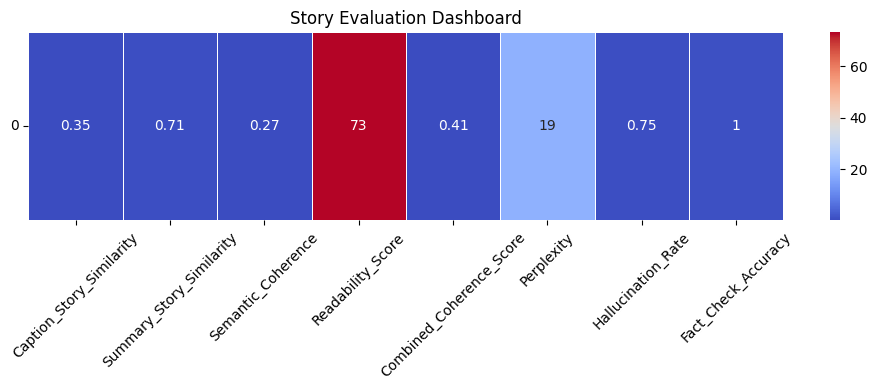

In [10]:
plt.figure(figsize=(10, 4))
sns.heatmap(metrics, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Story Evaluation Dashboard")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

#### Per-Act Evaluation Metrics

In [11]:
acts = re.split(r"\*\*Act [^\n]+\*\*", story_text)
acts = [act.strip() for act in acts if act.strip()]
acts = acts[1:]
act_results = []

for i, act_text in enumerate(acts):
    act_sents = sent_tokenize(act_text)
    caption_sim, summary_sim = evaluate_story(caption, summary, act_text)
    coherence, readability, combined = story_coherence_score(act_text)
    perplexity = calculate_perplexity(act_text)
    halluc_rate = hallucination_rate(sent_tokenize(summary), act_sents)
    fact_acc, _, _ = fact_check_accuracy(sent_tokenize(summary), act_sents)

    act_results.append({
        "Act": f"Act {i+1}",
        "Caption_Story_Similarity": caption_sim,
        "Summary_Story_Similarity": summary_sim,
        "Semantic_Coherence": coherence,
        "Readability_Score": readability,
        "Combined_Coherence_Score": combined,
        "Perplexity": perplexity,
        "Hallucination_Rate": halluc_rate,
        "Fact_Check_Accuracy": fact_acc
    })

act_df = pd.DataFrame(act_results)

print("\n=== Per-Act Evaluation Metrics ===")
display(act_df.set_index("Act").T)



=== Per-Act Evaluation Metrics ===


Act,Act 1,Act 2,Act 3
Caption_Story_Similarity,0.249880,0.092698,0.136485
Summary_Story_Similarity,0.560819,0.321373,0.489876
Semantic_Coherence,0.227150,0.270979,0.304002
Readability_Score,63.700000,75.910000,71.850000
Combined_Coherence_Score,0.350000,0.417000,0.428000
Perplexity,22.900000,21.615000,19.089000
Hallucination_Rate,0.792000,0.913000,0.579000
Fact_Check_Accuracy,1.000000,0.000000,0.750000


#### Per-Act Story Evaluation Heatmap

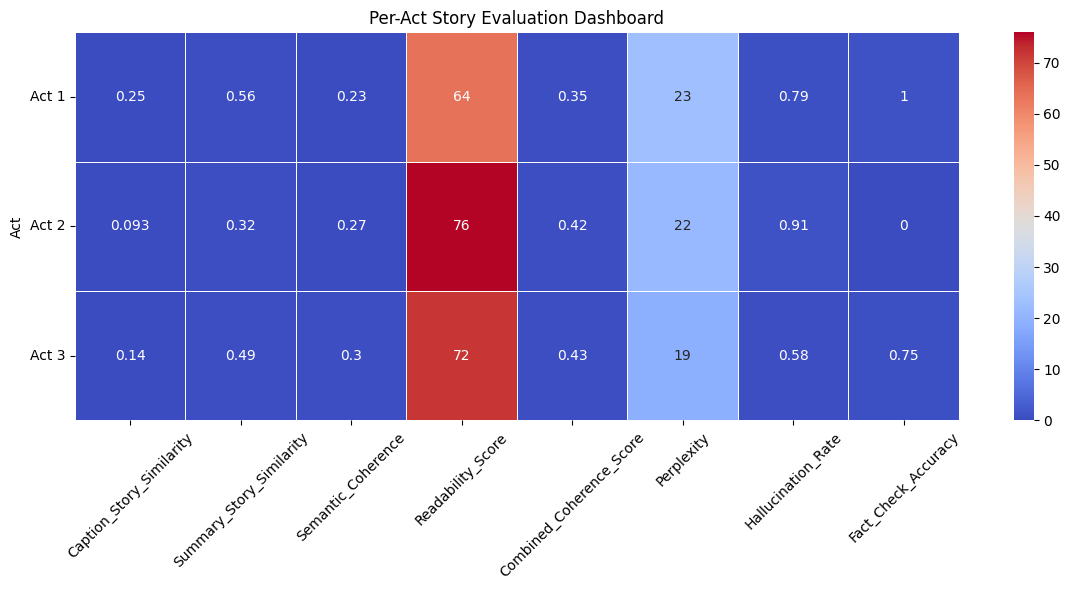

In [12]:
plt.figure(figsize=(12, 6))
sns.heatmap(act_df.set_index("Act"), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Per-Act Story Evaluation Dashboard")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

#### GPT-4 Analysis of the Generated Story

In [ ]:
client = openai.OpenAI(api_key = "your api key")

def gpt_human_analysis(caption, summary, story_text):
    prompt = f"""
You are a professional fiction editor. Please evaluate the following story based on:
1. Relevance to the provided image caption
2. Factual consistency with the background summary
3. Coherence and structure across acts
4. Fluency and natural language use
5. Originality and creativity

Provide a brief qualitative critique and a score from 0–10 for each of the five criteria above.

---

Caption: {caption}

Summary: {summary}

Story: {story_text}
"""

    response = client.chat.completions.create(
        model="gpt-4",
        messages=[
            {"role": "system", "content": "You are an expert story evaluator."},
            {"role": "user", "content": prompt}
        ]
    )

    return response.choices[0].message.content

print("GPT-4 Analysis of the Generated Story:\n")
gpt_review = gpt_human_analysis(caption, summary, story_text)
print(gpt_review)


GPT-4 Analysis of the Generated Story:

1. Relevance to the provided image caption: 10/10
The story directly correlates with the image described in the caption - a man in a red jacket riding a small horse. 

2. Factual consistency with the background summary: 10/10
The story accurately and creatively portrays the life and journey of Ern Pedler, sticking closely to the background summary provided. The time period seems consistent with the mid-20th century, and the story highlights his adventure, resilience, and the bond with his horse.

3. Coherence and structure across acts: 9/10
The story is appropriately divided into three acts: beginning, middle, and end. The flow between acts is coherent. However, the momentous encounter with the cattlemen could be more organically fit into the overall structure for a smoother progression.

4. Fluency and natural language use: 10/10
The language flows beautifully and naturally, painting vivid imagery and creating compelling dialogue. 

5. Originali